In [1]:
from keras.applications import VGG16
import os,sys
import numpy as np
import pandas
import matplotlib.pyplot as plt
from PIL import Image
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras import optimizers
import time
import glob
import cv2

Using TensorFlow backend.
c:\anaconda3\envs\rebuild_keras\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\anaconda3\envs\rebuild_keras\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\anaconda3\envs\rebuild_keras\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\anaconda3\envs\rebuild_keras\lib\site-packages\tensorflo

In [2]:
from keras import backend as K

if 'tensorflow' == K.backend():
    import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = "0"
set_session(tf.Session(config=config))

In [3]:
model_file_name = 'model_SDNET2018_256.hdf5'
model = load_model('../model/' + model_file_name)

In [4]:
crack = []
files = glob.glob("../data/crack3/*.jpg")
for i, file in enumerate(files):
        image = Image.open(file)
        image = image.convert("RGB")
        data = np.asarray(image)
        crack.append(data)
crack = np.array(crack)
crack = crack.astype('float32')
crack = crack / 255.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


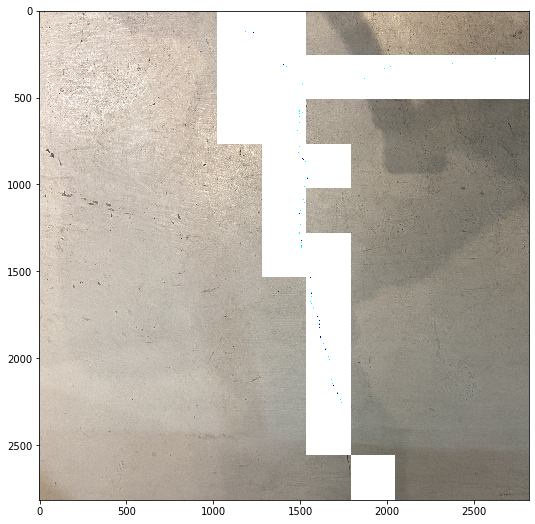

In [9]:
size = 256
dense_size = 2
img = crack[0]
pink_img = cv2.imread('../data/colormap/colormap2.png',1)
#pink_img = cv2.cvtColor(pink_img,cv2.COLOR_BGR2RGB)
pink_img = pink_img.astype('float32')
pink_img = pink_img / 255.0
pink_img = cv2.resize(pink_img,(size,size) )
v_size = img.shape[0] // size * size
h_size = img.shape[1] // size * size 
img = img[:v_size, :h_size]
v_split = img.shape[0] // size
h_split = img.shape[1] // size

out_imgs = []
k = 0
for h_img in np.vsplit(img, v_split):
    for v_img in np.hsplit(h_img, h_split):
        out_imgs.append(v_img)
out_imgs = np.array(out_imgs)

a = np_utils.to_categorical(0, dense_size)
predict = model.predict(out_imgs)
map = []
for i in range(len(out_imgs)):
    map.append(predict[i][0])
    
    #prei = predict[i:i+1] 
    if predict[i][0] <= 0.91:
         predict[i][0] = 0 
    #print(predict[i][0])
    
    if predict[i].argmax() == 0:
        #out_imgs[i] = cv2.addWeighted(out_imgs[i],0.5, pink_img,0.5,0.25)
        out_imgs[i] = out_imgs[i] * 255
        out_imgs[i] = np.uint8(out_imgs[i])
        out_imgs[i] = cv2.cvtColor(out_imgs[i],cv2.COLOR_BGR2RGB)
        cv2.imwrite('./image_256/img_256_{}.jpg'.format(i),out_imgs[i])

for i in range(v_split):
        for j in range(h_split):
            if k >= len(out_imgs):break
            im = out_imgs[k]
            if j == 0:im1 = im
            else:im1 = np.hstack((im1,im))
            k += 1
        if i == 0:im2 = im1
        else:im2 = np.vstack((im2,im1))
        if k>= len(out_imgs):break

fig = plt.figure(figsize=(16,9))
plt.imshow(im2)
plt.show()